# Preamble

In [1]:
import os

current_dir = os.getcwd()

print("Current working directory:", current_dir)

Current working directory: /work/mherre/master-projectV3/master-projectV2/notebooks


# Dataset Overview

In [2]:
import openml
import pandas as pd
import json
import os

def generate_dataset_overview():
    # Load dataset ids from json file
    json_file_path = os.path.join("../config", "config.json")
    with open(json_file_path, "r") as file:
        config = json.load(file)

    # Datasets are in data[datasets]
    dataset_ids = config["data"]["datasets"]

    # Convert dataset_ids to standard Python integers
    dataset_ids = [int(dataset_id) for dataset_id in dataset_ids]

    regression_data = []
    binary_data = []

    for dataset_id in dataset_ids:
        # Get dataset name from OpenML
        dataset = openml.datasets.get_dataset(dataset_id)
        name = dataset.name

        # Load the actual data to get features
        X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format="dataframe", target=dataset.default_target_attribute
        )

        # Calculate statistics
        n_samples = len(X)
        n_features = X.shape[1]
        n_cat_features = sum(categorical_indicator)

        # Determine if it's regression or binary classification
        if pd.api.types.is_numeric_dtype(y) and len(y.unique()) > 2:
            # Regression dataset
            task_type = "regression"
            data_entry = {
                "Name": name,
                "Samples": n_samples,
                "Features": n_features,
                "Cat Features": n_cat_features,
                "OpenML ID": dataset_id,
            }
            regression_data.append(data_entry)
        elif len(y.unique()) == 2:
            # Binary classification dataset
            task_type = "binary"
            value_counts = y.value_counts(normalize=True)
            minority_class_pct = min(value_counts) * 100
            
            data_entry = {
                "Name": name,
                "Samples": n_samples,
                "Features": n_features,
                "Cat Features": n_cat_features,
                "Minority Class (%)": round(minority_class_pct, 2),
                "OpenML ID": dataset_id,
            }
            binary_data.append(data_entry)

    # Create DataFrames
    regression_df = pd.DataFrame(regression_data)
    binary_df = pd.DataFrame(binary_data)

    # Define columns for each type
    regression_cols = ["Name", "Samples", "Features", "Cat Features", "OpenML ID"]
    binary_cols = ["Name", "Samples", "Features", "Cat Features", "Minority Class (%)", "OpenML ID"]

    # Reorder columns and sort by samples
    if not regression_df.empty:
        regression_df = regression_df[regression_cols].sort_values(by="Samples", ascending=True)
    
    if not binary_df.empty:
        binary_df = binary_df[binary_cols].sort_values(by="Samples", ascending=True)

    return regression_df, binary_df

In [3]:
# Generate the two separate tables
regression_table, binary_table = generate_dataset_overview()

print("REGRESSION DATASETS")
display(regression_table.style.hide(axis="index"))

print("\nBINARY CLASSIFICATION DATASETS")
display(binary_table.style.hide(axis="index").format({"Minority Class (%)": "{:.2f}"}))

REGRESSION DATASETS


Name,Samples,Features,Cat Features,OpenML ID
analcatdata_supreme,4052,7,0,504
wine_quality,6497,11,0,287
cpu_act,8192,21,0,197
visualizing_soil,8641,4,1,688
yprop_4_1,8885,251,0,416
sulfur,10081,6,0,23515
Brazilian_houses,10692,12,4,42688



BINARY CLASSIFICATION DATASETS


Name,Samples,Features,Cat Features,Minority Class (%),OpenML ID
dresses-sales,500,12,11,42.00,23381
climate-model-simulation-crashes,540,18,0,8.52,40994
cylinder-bands,540,37,19,42.22,6332
wdbc,569,30,0,37.26,1510
ilpd,583,10,1,28.64,1480
tokyo1,959,44,2,36.08,40705
qsar-biodeg,1055,41,0,33.74,1494
ozone-level-8hr,2534,72,0,6.31,1487
madelon,2600,500,0,50.00,1485
wilt,4839,5,0,5.39,40983


#  Performance Tables


In [4]:
import pandas as pd
import json
import os
import numpy as np
from IPython.display import display

def load_all_results():
    """Load all teacher and student results from the results directory."""
    results_dir = "../results"
    all_results = {}
    
    # Load teacher results
    teacher_dir = os.path.join(results_dir, "teacher")
    if os.path.exists(teacher_dir):
        for file in os.listdir(teacher_dir):
            if file.endswith("_results.json"):
                dataset_id = file.split("_")[0]
                with open(os.path.join(teacher_dir, file), 'r') as f:
                    teacher_data = json.load(f)
                
                if dataset_id not in all_results:
                    all_results[dataset_id] = {}
                
                for key, result in teacher_data.items():
                    model_type = result.get("model_type", "unknown")
                    task_type = result.get("task_type", "unknown")
                    all_results[dataset_id][f"{model_type}_teacher"] = result
    
    # Load student results
    student_dir = os.path.join(results_dir, "student")
    if os.path.exists(student_dir):
        for file in os.listdir(student_dir):
            if file.endswith("_results.json"):
                dataset_id = file.split("_")[0]
                with open(os.path.join(student_dir, file), 'r') as f:
                    student_data = json.load(f)
                
                if dataset_id not in all_results:
                    all_results[dataset_id] = {}
                
                for key, result in student_data.items():
                    student_model = result.get("student_model_type", "unknown")
                    teacher_model = result.get("teacher_model_type", "unknown")
                    task_type = result.get("student_task_type", result.get("task_type", "unknown"))
                    model_key = f"{student_model}({teacher_model})_student"
                    all_results[dataset_id][model_key] = result
    
    return all_results

def get_dataset_info():
    """Get dataset information including names and sizes."""
    json_file_path = os.path.join("../config", "config.json")
    with open(json_file_path, "r") as file:
        config = json.load(file)
    
    dataset_ids = [str(id) for id in config["data"]["datasets"]]
    
    # You can extend this to get actual dataset sizes from your data
    # For now, we'll use placeholder sizes or load from cached data
    dataset_info = {}
    
    # Try to get sizes from your cached data or OpenML
    import openml
    for dataset_id in dataset_ids:
        try:
            dataset = openml.datasets.get_dataset(int(dataset_id))
            X, y, _, _ = dataset.get_data(dataset_format="dataframe", target=dataset.default_target_attribute)
            dataset_info[dataset_id] = {
                'name': dataset.name,
                'size': len(X),
                'task_type': 'binary' if len(y.unique()) == 2 else 'regression'
            }
        except:
            dataset_info[dataset_id] = {
                'name': f'Dataset_{dataset_id}',
                'size': 0,
                'task_type': 'unknown'
            }
    
    return dataset_info

def create_results_table(metric='f1', task_filter=None, model_filter=None):
    """
    Create a comprehensive results table.
    
    Parameters:
    -----------
    metric : str
        The metric to display (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    model_filter : str or None
        Filter by model type ('teacher', 'student', 'both', or None for all).
        If None, defaults to 'both'.
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    table_data = []
    
    for dataset_id, models_data_for_dataset in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        current_dataset_info = dataset_info[dataset_id]
        
        # Filter by task type if specified
        if task_filter and current_dataset_info['task_type'] != task_filter:
            continue

        # Initialize row with dataset-specific info
        row = {
            'Dataset ID': dataset_id,
            'Dataset Name': current_dataset_info['name'],
            'Size': current_dataset_info['size'],
            'Task Type': current_dataset_info['task_type']
        }
        
        at_least_one_filtered_model_has_data = False
        
        for model_name, result in models_data_for_dataset.items():
            # Determine if this model should be included based on model_filter
            include_this_model = False
            if model_filter == 'teacher':
                if model_name.endswith('_teacher'):
                    include_this_model = True
            elif model_filter == 'student':
                if model_name.endswith('_student'):
                    include_this_model = True
            elif model_filter == 'both' or model_filter is None: # Treat None as 'both'
                include_this_model = True
            # else: model_filter is an unexpected value, model is not included.

            if include_this_model:
                mean_key = f"mean_{metric}"
                std_key = f"std_{metric}"
                
                if mean_key in result and std_key in result:
                    mean_val = result[mean_key]
                    std_val = result[std_key]
                    row[model_name] = f"{mean_val:.4f} ± {std_val:.4f}" if metric == "inference_time" else f"{mean_val:.3f} ± {std_val:.3f}" 
                    at_least_one_filtered_model_has_data = True
                elif metric in result:  # Fallback if no std available
                    row[model_name] = f"{result[metric]:.3f}"
                    at_least_one_filtered_model_has_data = True
                else:
                    # Model is selected by filter, but lacks the specific metric.
                    # Add it as a column with "N/A".
                    row[model_name] = "N/A"
        
        # If no model that passed the filter actually had the metric data, skip this dataset row.
        if not at_least_one_filtered_model_has_data:
            continue
            
        table_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    if df.empty:
        print(f"No results found for metric '{metric}' with task filter '{task_filter}' and model filter '{model_filter}'")
        return df
    
    # Sort by dataset size
    df = df.sort_values('Size', ascending=True)
    
    # Reorder columns: Dataset info first, then models
    info_cols = ['Dataset ID', 'Dataset Name', 'Size', 'Task Type']
    # Model columns are dynamically determined by what was added to the rows
    model_cols = [col for col in df.columns if col not in info_cols]
    df = df[info_cols + sorted(model_cols)]
    
    return df

def display_results_table(metric='f1', task_filter=None, model_filter=None):
    """Display the results table with styling."""
    df = create_results_table(metric, task_filter, model_filter)
    
    if df.empty:
        return
    
    print(f"Results Table - Metric: {metric.upper()}")
    if task_filter:
        print(f"Task Filter: {task_filter}")
    print("="*80)
    
    # Style the table
    styled_df = df.style.hide(axis="index")
    
    # Apply formatting
    styled_df = styled_df.format({
        'Size': '{:,}',
        'Dataset ID': lambda x: str(x)
    })
    
    display(styled_df)
    
    return df


In [5]:
# First, let's see what metrics are available
print("\n" + "="*50)
table = display_results_table(metric='f1', task_filter='binary', model_filter='teacher')

# Export table to CSV
if not table.empty:
    output_csv_path = os.path.join("../results", "inference_time_binary_teacher_results.csv")
    table.to_csv(output_csv_path, index=False)
    print(f"Results exported to {output_csv_path}")


Results Table - Metric: F1
Task Filter: binary


Dataset ID,Dataset Name,Size,Task Type,catboost_teacher,grande_teacher,mlp_teacher,random_forest_teacher,tabm_teacher,tabpfn_teacher
23381,dresses-sales,500,binary,0.504 ± 0.025,0.596 ± 0.045,0.543 ± 0.061,0.584 ± 0.034,0.582 ± 0.057,0.599 ± 0.052
40994,climate-model-simulation-crashes,540,binary,0.709 ± 0.087,0.787 ± 0.083,0.775 ± 0.063,0.554 ± 0.079,0.842 ± 0.047,0.811 ± 0.105
6332,cylinder-bands,540,binary,0.786 ± 0.031,0.755 ± 0.023,0.779 ± 0.042,0.799 ± 0.036,0.763 ± 0.058,0.753 ± 0.050
1510,wdbc,569,binary,0.943 ± 0.039,0.968 ± 0.009,0.974 ± 0.010,0.951 ± 0.016,0.974 ± 0.008,0.974 ± 0.011
1480,ilpd,583,binary,0.564 ± 0.021,0.597 ± 0.033,0.579 ± 0.032,0.579 ± 0.043,0.562 ± 0.030,0.528 ± 0.022
40705,tokyo1,959,binary,0.916 ± 0.012,0.919 ± 0.021,0.904 ± 0.027,0.925 ± 0.017,0.915 ± 0.017,0.915 ± 0.013
1494,qsar-biodeg,"1,055",binary,0.853 ± 0.015,0.856 ± 0.016,0.856 ± 0.025,0.857 ± 0.007,0.864 ± 0.013,0.865 ± 0.017
1487,ozone-level-8hr,"2,534",binary,0.587 ± 0.054,0.691 ± 0.054,0.712 ± 0.026,0.590 ± 0.050,0.738 ± 0.035,0.695 ± 0.048
1485,madelon,"2,600",binary,0.840 ± 0.017,0.798 ± 0.019,0.558 ± 0.021,0.726 ± 0.019,0.596 ± 0.013,0.895 ± 0.006
40983,wilt,"4,839",binary,0.924 ± 0.016,0.939 ± 0.016,0.930 ± 0.008,0.908 ± 0.020,0.931 ± 0.015,0.944 ± 0.015


Results exported to ../results/inference_time_binary_teacher_results.csv


# Normalized Mean and MRR

In [6]:
def calculate_normalized_mean_and_mrr(metric='f1', task_filter=None, model_filter='both'):
    """
    Calculate normalized mean performance, standard mean, and Mean Reciprocal Rank (MRR) across all datasets and models.
    
    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    model_filter : str
        Which models to include ('teacher', 'student', or 'both')
    
    Returns:
    --------
    dict: Contains normalized means, standard means, and MRR for each model
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    # Determine if lower is better for this metric
    lower_is_better = metric.lower() in ['mae', 'mse', 'rmse', 'loss', 'inference_time']
    
    # Collect all model performances per dataset
    dataset_performances = {}  # {dataset_id: {model_name: performance}}
    all_models = set()
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        # Filter by task type if specified
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        dataset_performances[dataset_id] = {}
        
        for model_name, result in models.items():
            # Apply model filter
            if model_filter == 'teacher' and not model_name.endswith('_teacher'):
                continue
            elif model_filter == 'student' and not model_name.endswith('_student'):
                continue
            elif model_filter == 'both':
                pass  # Include all models
            
            mean_key = f"mean_{metric}"
            if mean_key in result:
                performance = result[mean_key]
                dataset_performances[dataset_id][model_name] = performance
                all_models.add(model_name)
    
    if not dataset_performances:
        print(f"No data found for metric '{metric}' with given filters")
        return {}
    
    # Calculate normalized performances, standard means, and ranks for each dataset
    normalized_performances = {model: [] for model in all_models}
    standard_performances = {model: [] for model in all_models}  # Added for standard mean
    reciprocal_ranks = {model: [] for model in all_models}
    
    for dataset_id, model_perfs in dataset_performances.items():
        if len(model_perfs) < 2:  # Need at least 2 models to normalize
            continue
            
        # Get performance values
        performances = list(model_perfs.values())
        model_names = list(model_perfs.keys())
        
        # Store raw performances for standard mean calculation
        for model_name, perf in model_perfs.items():
            standard_performances[model_name].append(perf)
        
        # Calculate min and max for normalization
        min_perf = min(performances)
        max_perf = max(performances)
        
        # Avoid division by zero
        if max_perf == min_perf:
            # All models perform equally, assign normalized score of 1.0 to all
            for model_name in model_names:
                normalized_performances[model_name].append(1.0)
                reciprocal_ranks[model_name].append(1.0)  # All tied for first place
            continue
        
        # Normalize performances to [0, 1]
        normalized_dataset_perfs = {}
        for model_name, perf in model_perfs.items():
            if lower_is_better:
                # For metrics where lower is better, invert the normalization
                normalized_perf = (max_perf - perf) / (max_perf - min_perf)
            else:
                # For metrics where higher is better
                normalized_perf = (perf - min_perf) / (max_perf - min_perf)
            
            normalized_dataset_perfs[model_name] = normalized_perf
            normalized_performances[model_name].append(normalized_perf)
        
        # Calculate ranks (1 = best, 2 = second best, etc.)
        if lower_is_better:
            sorted_models = sorted(model_perfs.items(), key=lambda x: x[1])  # ascending for lower is better
        else:
            sorted_models = sorted(model_perfs.items(), key=lambda x: x[1], reverse=True)  # descending for higher is better
        
        # Handle ties by assigning average rank
        ranks = {}
        current_rank = 1
        i = 0
        while i < len(sorted_models):
            # Find all models with the same performance
            current_perf = sorted_models[i][1]
            tied_models = [sorted_models[i][0]]
            j = i + 1
            while j < len(sorted_models) and sorted_models[j][1] == current_perf:
                tied_models.append(sorted_models[j][0])
                j += 1
            
            # Assign average rank to tied models
            if len(tied_models) == 1:
                ranks[tied_models[0]] = current_rank
            else:
                avg_rank = current_rank + (len(tied_models) - 1) / 2
                for model in tied_models:
                    ranks[model] = avg_rank
            
            current_rank += len(tied_models)
            i = j
        
        # Calculate reciprocal ranks
        for model_name in model_names:
            rank = ranks[model_name]
            reciprocal_ranks[model_name].append(1.0 / rank)
    
    # Calculate final metrics
    results = {}
    for model in all_models:
        if normalized_performances[model]:  # Only include models with data
            norm_mean = np.mean(normalized_performances[model])
            standard_mean = np.mean(standard_performances[model])  # Added standard mean
            mrr = np.mean(reciprocal_ranks[model])
            results[model] = {
                'normalized_mean': norm_mean,
                'standard_mean': standard_mean,  # Added standard mean
                'mrr': mrr,
                'num_datasets': len(normalized_performances[model])
            }
    
    return results


def prettify(key: str) -> str:
    """Convert `tabpfn_teacher` → `TabPFN (Teacher)`."""
    # 1) drop trailing "_teacher" / "_student" if present
    base = key.rsplit('_', 1)[0] if key.endswith(('_teacher', '_student')) else key

    # 2) explicit dictionary for the spellings you want
    mapping = {
        'tabpfn'      : 'TabPFN',
        'tabm'        : 'TabM',
        'grande'      : 'GRANDE',
        'catboost'    : 'CatBoost',
        'mlp'         : 'MLP',
        'random_forest' : 'RForest',
        # add more if needed
    }

    return mapping.get(base.lower(), base.replace('_', ' ').title())

def display_normalized_results(metric='f1', task_filter=None, model_filter='both'):
    """Display normalized mean, standard mean, and MRR results in a formatted table."""
    results = calculate_normalized_mean_and_mrr(metric, task_filter, model_filter)
    
    if not results:
        print("No results to display")
        return
    
    # Create DataFrame
    data = []
    for model_name, metrics in results.items():
        data.append({
            'Model': prettify(model_name),
            'Standard Mean': metrics['standard_mean'],  # Added standard mean
            'Normalized Mean': metrics['normalized_mean'],
            'MRR': metrics['mrr'],
            'Datasets': metrics['num_datasets']
        })
    
    df = pd.DataFrame(data)
    
    # Sort by normalized mean (descending)
    df = df.sort_values('Normalized Mean', ascending=False)
    
    print(f"\nPerformance Results - Metric: {metric.upper()}")
    if task_filter:
        print(f"Task Filter: {task_filter}")
    print(f"Model Filter: {model_filter}")
    print("="*80)
    print("Standard Mean: Raw arithmetic mean across datasets")
    print("Normalized Mean: Performance normalized to [0,1] across datasets")
    print("MRR: Mean Reciprocal Rank (higher is better)")
    print("="*80)
    
    # Style the table
    styled_df = df.style.hide(axis="index").format({
        'Standard Mean': '{:.4f}',  # Added formatting for standard mean
        'Normalized Mean': '{:.4f}',
        'MRR': '{:.4f}',
        'Datasets': '{:d}'
    })
    
    display(styled_df)
    
    return df

In [7]:
table = display_normalized_results(metric='inference_time', task_filter='binary', model_filter='teacher')


Performance Results - Metric: INFERENCE_TIME
Task Filter: binary
Model Filter: teacher
Standard Mean: Raw arithmetic mean across datasets
Normalized Mean: Performance normalized to [0,1] across datasets
MRR: Mean Reciprocal Rank (higher is better)


Model,Standard Mean,Normalized Mean,MRR,Datasets
MLP,0.0014,1.0000,1.0000,14
CatBoost,0.0234,0.9964,0.4286,14
TabM,0.0144,0.9947,0.4048,14
RForest,0.1984,0.8776,0.2500,14
TabPFN,4.7691,0.4347,0.1905,14
GRANDE,1.4234,0.1864,0.1762,14


# Cumulative Performance Plot

In [8]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np

def calculate_best_model_frequencies(metric='f1', task_filter=None, model_filter='both'):
    """
    Calculate how often each model performs best across datasets.
    
    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2')
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all)
    model_filter : str
        Which models to include ('teacher', 'student', or 'both')
    
    Returns:
    --------
    dict: Model names and their frequencies of being best
    """
    all_results = load_all_results()
    dataset_info = get_dataset_info()
    
    model_best_counts = {}
    total_datasets = 0
    
    for dataset_id, models in all_results.items():
        if dataset_id not in dataset_info:
            continue
            
        # Filter by task type if specified
        if task_filter and dataset_info[dataset_id]['task_type'] != task_filter:
            continue
        
        # Filter models based on model_filter
        filtered_models = {}
        for model_name, result in models.items():
            if model_filter == 'teacher' and not model_name.endswith('_teacher'):
                continue
            elif model_filter == 'student' and not model_name.endswith('_student'):
                continue
            elif model_filter == 'both':
                pass  # Include all models
            
            mean_key = f"mean_{metric}"
            if mean_key in result:
                filtered_models[model_name] = result[mean_key]
        
        if not filtered_models:
            continue
            
        # Find the best model for this dataset
        # For metrics like mae, mse, rmse - lower is better
        # For metrics like f1, acc, roc, r2 - higher is better
        lower_is_better = metric.lower() in ['mae', 'mse', 'rmse', 'loss', 'inference_time']
        
        if lower_is_better:
            best_model = min(filtered_models, key=filtered_models.get)
        else:
            best_model = max(filtered_models, key=filtered_models.get)
        
        # Count this best model
        if best_model not in model_best_counts:
            model_best_counts[best_model] = 0
        model_best_counts[best_model] += 1
        total_datasets += 1
    
    # Convert counts to frequencies
    model_frequencies = {}
    for model, count in model_best_counts.items():
        model_frequencies[model] = count / total_datasets if total_datasets > 0 else 0
    
    return model_frequencies, total_datasets

def prettify(key: str) -> str:
    """Convert `tabpfn_teacher` → `TabPFN (Teacher)`."""
    # 1) drop trailing "_teacher" / "_student" if present
    base = key.rsplit('_', 1)[0] if key.endswith(('_teacher', '_student')) else key

    # 2) explicit dictionary for the spellings you want
    mapping = {
        'tabpfn'      : 'TabPFN',
        'tabm'        : 'TabM',
        'grande'      : 'GRANDE',
        'catboost'    : 'CatBoost',
        'mlp'         : 'MLP',
        'random_forest' : 'RForest',
        # add more if needed
    }

    return mapping.get(base.lower(), base.replace('_', ' ').title())


def plot_cumulative_optimal_achievements(metric='f1', task_filter=None, model_filter='both',
                                         figsize=(14, 10), save_path=None):
    """
    Create a cumulative bar plot showing the percentage of optimal achievements for each model.
    Models are sorted by performance, and bars are stacked horizontally on different y-levels.
    Includes all participating models, even those with zero optimal achievements.

    Parameters:
    -----------
    metric : str
        The metric to evaluate (e.g., 'f1', 'acc', 'roc', 'mae', 'mse', 'rmse', 'r2').
    task_filter : str or None
        Filter by task type ('binary', 'regression', or None for all).
    model_filter : str
        Which models to include ('teacher', 'student', or 'both').
    figsize : tuple
        Figure size (width, height).
    save_path : str or None
        Path to save the plot (if None, just display).
    """
    # 1. Get win frequencies for models that were best
    win_frequencies, total_datasets = calculate_best_model_frequencies(
        metric, task_filter, model_filter
    )

    if total_datasets == 0:
        print(f"No datasets analyzed for metric '{metric}' with filters: task='{task_filter}', model='{model_filter}'. Cannot generate plot.")
        # Still, we might want to show models with 0% if they exist.
        # Let's proceed to find all participating models.

    # 2. Get all models that participated under the given filters and had the metric
    all_participating_models = set()
    raw_results = load_all_results()
    dataset_details = get_dataset_info()

    for dataset_id, model_results_for_dataset in raw_results.items():
        dataset_task_type = dataset_details.get(dataset_id, {}).get('task_type')
        if task_filter and dataset_task_type != task_filter:
            continue

        for model_key, result_data in model_results_for_dataset.items():
            # Apply model filter
            if model_filter == 'teacher' and not model_key.endswith('_teacher'):
                continue
            if model_filter == 'student' and not model_key.endswith('_student'):
                continue
            
            # Check if this model has the required metric
            mean_key = f"mean_{metric}"
            if mean_key in result_data:
                 all_participating_models.add(model_key)

    if not all_participating_models:
        print(f"No participating models found for metric '{metric}' with filters: task='{task_filter}', model='{model_filter}'.")
        return

    # 3. Combine win frequencies with all participating models (defaulting to 0 if never won)
    plot_data = {}
    for model_name in all_participating_models:
        plot_data[model_name] = win_frequencies.get(model_name, 0.0)

    # ------------------------------------------------------------------
    # 2.  Prepare the plotting data  (unchanged)
    # ------------------------------------------------------------------
    sorted_models_by_freq = sorted(plot_data.items(),
                                   key=lambda x: x[1], reverse=True)
    model_names            = [m for m, _ in sorted_models_by_freq]
    pretty_names = [prettify(n) for n in model_names]
    individual_frequencies = np.array([f for _, f in sorted_models_by_freq])

    cumulative_offset          = 0.0
    bar_left_positions         = []
    actual_bar_widths_percent  = []

    for freq in individual_frequencies:
        pct = freq * 100
        bar_left_positions.append(cumulative_offset)
        actual_bar_widths_percent.append(pct)
        cumulative_offset += pct

    # ------------------------------------------------------------------
    # 3.  Plot with SciencePlots (science + ieee + no-latex)
    # ------------------------------------------------------------------
    with plt.style.context(['science',      # base look & feel
                            'ieee',         # fonts / sizes for IEEE papers
                            'no-latex']):   # disable TeX rendering

        # optional: override the very small ieee default dpi
        plt.rcParams.update({'figure.dpi': 150})

        fig, ax = plt.subplots(figsize=(4.5,2.5))

        renderer   = fig.canvas.get_renderer()        # for pixel math
        bbox       = ax.get_window_extent(renderer)
        axis_width = bbox.width

        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        for i, (pretty, width_val, left_pos) in enumerate(
                zip(pretty_names, actual_bar_widths_percent, bar_left_positions)):
            ax.barh(pretty, width_val, left=left_pos,
                    # height=0.9,
                    color=color_cycle[i % len(color_cycle)],
                    edgecolor='black', alpha=0.85)
            
            width_px = (width_val / ax.get_xlim()[1]) * axis_width
            if width_px > 40:                         # threshold; tweak as you like
                ax.text(left_pos + width_val / 2, pretty,
                        f'{width_val:.2f}%', ha='center', va='center',
                        color='white' if width_val > 5 else 'black')

        # styling
        ax.invert_yaxis()
        ax.set_xlabel('Optimal Achievement Rate (%)', fontsize=12)
        ax.set_ylabel('Method', fontsize=12)
        ax.set_xlim(0, max(100.0, cumulative_offset * 1.05))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
        ax.xaxis.grid(True, linestyle='--', alpha=0.5)
        ax.set_axisbelow(True)
        ax.tick_params(axis='both', which='major', labelsize=10)

        plt.tight_layout()

        if save_path:
            # Ensure the directory exists
            save_path = os.path.join(save_path, f'cumulative_optimal_achievements_{metric}_{task_filter or "all"}_{model_filter}.pdf')
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            # Save the figure
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Plot saved to: {save_path}')

        plt.show() 

    # Optional: Print summary
    print(f"\nSummary for {metric.upper()} ({task_filter if task_filter else 'all'} tasks, {model_filter} models):")
    print(f"Total datasets analyzed: {total_datasets}")
    print("\nModel Contributions to Optimal Achievements:")
    current_sum_print = 0
    for i, model_name in enumerate(model_names):
        ind_freq_perc = individual_frequencies[i] * 100
        current_sum_print += ind_freq_perc
        print(f"{i+1:2d}. {model_name:<40s}: {ind_freq_perc:>6.2f}% (Cumulative: {current_sum_print:>6.2f}%)")

Plot saved to: visual_outputs/cumulative_optimal_achievements_f1_binary_teacher.pdf


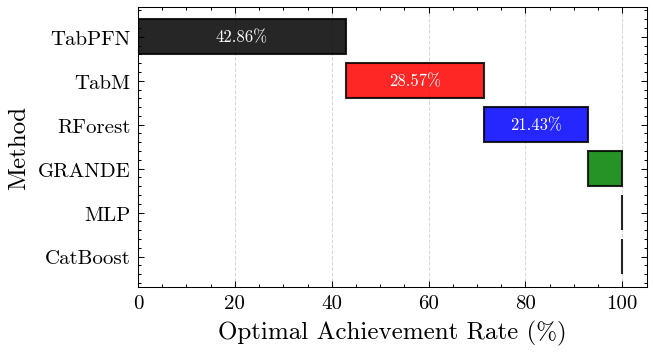


Summary for F1 (binary tasks, teacher models):
Total datasets analyzed: 14

Model Contributions to Optimal Achievements:
 1. tabpfn_teacher                          :  42.86% (Cumulative:  42.86%)
 2. tabm_teacher                            :  28.57% (Cumulative:  71.43%)
 3. random_forest_teacher                   :  21.43% (Cumulative:  92.86%)
 4. grande_teacher                          :   7.14% (Cumulative: 100.00%)
 5. mlp_teacher                             :   0.00% (Cumulative: 100.00%)
 6. catboost_teacher                        :   0.00% (Cumulative: 100.00%)


In [9]:
# Example 1: Cumulative F1 score for binary classification (both teacher and student models)
plot_cumulative_optimal_achievements(metric='f1', task_filter='binary', model_filter='teacher', save_path='visual_outputs')